<a href="https://colab.research.google.com/github/ZhiquanW/Learn-CUDA-Repository/blob/master/Copy_of_udacity_cs344_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Homework 2 for Udacity CS344 Course, Intro to Parallel Programming
# clone the code repo,
!git clone https://github.com/depctg/udacity-cs344-colab
!pip install git+git://github.com/depctg/nvcc4jupyter.git

# load cuda plugin
%config NVCCPluginV2.static_dir = True
%config NVCCPluginV2.relative_dir = "udacity-cs344-colab/src/HW2"
%load_ext nvcc_plugin

# change to work directory, generate makefiles
!mkdir udacity-cs344-colab/build
%cd udacity-cs344-colab/build
!cmake ../src

Cloning into 'udacity-cs344-colab'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 144 (delta 43), reused 100 (delta 28), pack-reused 0
Receiving objects: 100% (144/144), 3.94 MiB | 40.71 MiB/s, done.
Resolving deltas: 100% (43/43), done.
  Cloning git://github.com/depctg/nvcc4jupyter.git to /tmp/pip-req-build-lyxx8ol5
  Stored in directory: /tmp/pip-ephem-wheel-cache-kb71ymsj/wheels/1e/43/2d/099cad2b9b02dfa88573f50a22735d8a0b2ba69bf82167b81c
Successfully built NVCCPlugin
Set up cuda environment at /content/udacity-cs344-colab/src/HW2
Default out bin result.out
/content/udacity-cs344-colab/build
-- The C compiler identification is GNU 7.3.0
-- The CXX compiler identification is GNU 7.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile 

In [0]:
%%cuda --name student_func.cu

// Homework 2
// Image Blurring
//
// In this homework we are blurring an image. To do this, imagine that we have
// a square array of weight values. For each pixel in the image, imagine that we
// overlay this square array of weights on top of the image such that the center
// of the weight array is aligned with the current pixel. To compute a blurred
// pixel value, we multiply each pair of numbers that line up. In other words, we
// multiply each weight with the pixel underneath it. Finally, we add up all of the
// multiplied numbers and assign that value to our output for the current pixel.
// We repeat this process for all the pixels in the image.

// To help get you started, we have included some useful notes here.

//****************************************************************************

// For a color image that has multiple channels, we suggest separating
// the different color channels so that each color is stored contiguously
// instead of being interleaved. This will simplify your code.

// That is instead of RGBARGBARGBARGBA... we suggest transforming to three
// arrays (as in the previous homework we ignore the alpha channel again):
//  1) RRRRRRRR...
//  2) GGGGGGGG...
//  3) BBBBBBBB...
//
// The original layout is known an Array of Structures (AoS) whereas the
// format we are converting to is known as a Structure of Arrays (SoA).

// As a warm-up, we will ask you to write the kernel that performs this
// separation. You should then write the "meat" of the assignment,
// which is the kernel that performs the actual blur. We provide code that
// re-combines your blurred results for each color channel.

//****************************************************************************

// You must fill in the gaussian_blur kernel to perform the blurring of the
// inputChannel, using the array of weights, and put the result in the outputChannel.

// Here is an example of computing a blur, using a weighted average, for a single
// pixel in a small image.
//
// Array of weights:
//
//  0.0  0.2  0.0
//  0.2  0.2  0.2
//  0.0  0.2  0.0
//
// Image (note that we align the array of weights to the center of the box):
//
//    1  2  5  2  0  3
//       -------
//    3 |2  5  1| 6  0       0.0*2 + 0.2*5 + 0.0*1 +
//      |       |
//    4 |3  6  2| 1  4   ->  0.2*3 + 0.2*6 + 0.2*2 +   ->  3.2
//      |       |
//    0 |4  0  3| 4  2       0.0*4 + 0.2*0 + 0.0*3
//       -------
//    9  6  5  0  3  9
//
//         (1)                         (2)                 (3)
//
// A good starting place is to map each thread to a pixel as you have before.
// Then every thread can perform steps 2 and 3 in the diagram above
// completely independently of one another.

// Note that the array of weights is square, so its height is the same as its width.
// We refer to the array of weights as a filter, and we refer to its width with the
// variable filterWidth.

//****************************************************************************

// Your homework submission will be evaluated based on correctness and speed.
// We test each pixel against a reference solution. If any pixel differs by
// more than some small threshold value, the system will tell you that your
// solution is incorrect, and it will let you try again.

// Once you have gotten that working correctly, then you can think about using
// shared memory and having the threads cooperate to achieve better performance.

//****************************************************************************

// Also note that we've supplied a helpful debugging function called checkCudaErrors.
// You should wrap your allocation and copying statements like we've done in the
// code we're supplying you. Here is an example of the unsafe way to allocate
// memory on the GPU:
//
// cudaMalloc(&d_red, sizeof(unsigned char) * numRows * numCols);
//
// Here is an example of the safe way to do the same thing:
//
// checkCudaErrors(cudaMalloc(&d_red, sizeof(unsigned char) * numRows * numCols));
//
// Writing code the safe way requires slightly more typing, but is very helpful for
// catching mistakes. If you write code the unsafe way and you make a mistake, then
// any subsequent kernels won't compute anything, and it will be hard to figure out
// why. Writing code the safe way will inform you as soon as you make a mistake.

// Finally, remember to free the memory you allocate at the end of the function.

//****************************************************************************

#include "utils.h"
#include <cmath>
#include <cassert>
#include <stdio.h>
__global__
void gaussian_blur(const unsigned char* const inputChannel,
                   unsigned char* const outputChannel,
                   int numRows, int numCols,
                   const float* const filter, const int filterWidth){
  // TODO

  // NOTE: Be sure to compute any intermediate results in floating point
  // before storing the final result as unsigned char.

  // NOTE: Be careful not to try to access memory that is outside the bounds of
  // the image. You'll want code that performs the following check before accessing
  // GPU memory:
  //
  // if ( absolute_image_position_x >= numCols ||
  //      absolute_image_position_y >= numRows )
  // {
  //     return;
  // }

  // NOTE: If a thread's absolute position 2D position is within the image, but some of
  // its neighbors are outside the image, then you will need to be extra careful. Instead
  // of trying to read such a neighbor value from GPU memory (which won't work because
  // the value is out of bounds), you should explicitly clamp the neighbor values you read
  // to be within the bounds of the image. If this is not clear to you, then please refer
  // to sequential reference solution for the exact clamping semantics you should follow.
    int image_c = blockIdx.x * blockDim.x + threadIdx.x;
    int image_r = blockIdx.y * blockDim.y + threadIdx.y;
    if(image_r >= numRows || image_c >= numCols ){
        return;
    }
    float tmp_value = 0;
    int left_index = -filterWidth/2;
    int right_index = filterWidth/2+1;
    for(int filter_r = left_index;filter_r < right_index;++ filter_r){
        for(int filter_c = left_index;filter_c < right_index;++ filter_c){
            int tmp_r = min(max(image_r+filter_r,0),numRows-1);
            int tmp_c = min(max(image_c+filter_c,0),numCols-1);
            float image_value = static_cast<float>(inputChannel[tmp_r*numCols+tmp_c]);
            float filter_value = filter[(filter_r+filterWidth/2)*filterWidth+filter_c+filterWidth/2];
            tmp_value += image_value * filter_value;
        }
    }
    outputChannel[image_r *numCols+image_c] = tmp_value;
}

//This kernel takes in an image represented as a uchar4 and splits
//it into three images consisting of only one color channel each
__global__
void separateChannels(const uchar4* const inputImageRGBA,
                      int numRows,
                      int numCols,f 
                      unsigned char* const redChannel,
                      unsigned char* const greenChannel,
                      unsigned char* const blueChannel){
  // TODO
  //
  // NOTE: Be careful not to try to access memory that is outside the bounds of
  // the image. You'll want code that performs the following check before accessing
  // GPU memory:
  //
  // if ( absolute_image_position_x >= numCols ||
  //      absolute_image_position_y >= numRows )
  // {
  //     return;
  // }
    int image_c = blockIdx.x * blockDim.x + threadIdx.x;
    int image_r = blockIdx.y * blockDim.y + threadIdx.y;
    int tmp_index = image_r * numCols + image_c;

    if (image_r >= numRows || image_c >= numCols ){
       return;
    }
    redChannel[tmp_index] = inputImageRGBA[tmp_index].x;
    greenChannel[tmp_index] = inputImageRGBA[tmp_index].y;
    blueChannel[tmp_index] = inputImageRGBA[tmp_index].z;
}
         ombines them
//into one image.  The alpha channel is set to 255 to represent
//that this image has no transparency.
__global__
void recombineChannels(const unsigned char* const redChannel,
                       const unsigned char* const greenChannel,
                       const unsigned char* const blueChannel,
                       uchar4* const outputImageRGBA,
                       int numRows,
                       int numCols){
  const int2 thread_2D_pos = make_int2( blockIdx.x * blockDim.x + threadIdx.x,
                                        blockIdx.y * blockDim.y + threadIdx.y);

  const int thread_1D_pos = thread_2D_pos.y * numCols + thread_2D_pos.x;

  //make sure we don't try and access memory outside the image
  //by having any threads mapped there return early
  if (thread_2D_pos.x >= numCols || thread_2D_pos.y >= numRows)
    return;

  unsigned char red   = redChannel[thread_1D_pos];
  unsigned char green = greenChannel[thread_1D_pos];
  unsigned char blue  = blueChannel[thread_1D_pos];

  //Alpha should be 255 for no transparency
  uchar4 outputPixel = make_uchar4(red, green, blue, 255);


  outputImageRGBA[thread_1D_pos] = outputPixel;
}

unsigned char *d_red, *d_green, *d_blue;
float         *d_filter;

void allocateMemoryAndCopyToGPU(const size_t numRowsImage, const size_t numColsImage,
                                const float* const h_filter, const size_t filterWidth){

  //allocate memory for the three different channels
  //original
  checkCudaErrors(cudaMalloc(&d_red,   sizeof(unsigned char) * numRowsImage * numColsImage));
  checkCudaErrors(cudaMalloc(&d_green, sizeof(unsigned char) * numRowsImage * numColsImage));
  checkCudaErrors(cudaMalloc(&d_blue,  sizeof(unsigned char) * numRowsImage * numColsImage));

  //TODO:
  //Allocate memory for the filter on the GPU
  //Use the pointer d_filter that we have already declared for you
  //You need to allocate memory for the filter with cudaMalloc
  //be sure to use checkCudaErrors like the above examples to
  //be able to tell if anything goes wrong
  //IMPORTANT: Notice that we pass a pointer to a pointer to cudaMalloc
    checkCudaErrors(cudaMalloc(&d_filter,sizeof(float)*filterWidth*filterWidth));

  //TODO:
  //Copy the filter on the host (h_filter) to the memory you just allocated
  //on the GPU.  cudaMemcpy(dst, src, numBytes, cudaMemcpyHostToDevice);
  //Remember to use checkCudaErrors!
    checkCudaErrors(cudaMemcpy(d_filter, h_filter, sizeof(float) * filterWidth * filterWidth, cudaMemcpyHostToDevice));
}

void your_gaussian_blur(const uchar4 * const h_inputImageRGBA, uchar4 * const d_inputImageRGBA,
                        uchar4* const d_outputImageRGBA, const size_t numRows, const size_t numCols,
                        unsigned char *d_redBlurred,
                        unsigned char *d_greenBlurred,
                        unsigned char *d_blueBlurred,
                        const int filterWidth){
  //TODO: Set reasonable block size (i.e., number of threads per block)
    const int block_len = 32;
    const dim3 blockSize(block_len,block_len);

  //TODO:
  //Compute correct grid size (i.e., number of blocks per kernel launch)
  //from the image size and and block size.
    const int grid_width = (numCols-1)/block_len+1;
    const int grid_height = (numRows-1)/block_len +1;
    const dim3 gridSize(grid_width,grid_height);

  //TODO: Launch a kernel for separating the RGBA image into different color channels
    separateChannels<<<gridSize,blockSize>>>(d_inputImageRGBA,
                                             numRows,
                                             numCols,
                                             d_red,
                                             d_green,
                                             d_blue);
    
  // Call cudaDeviceSynchronize(), then call checkCudaErrors() immediately after
  // launching your kernel to make sure that you didn't make any mistakes.
    
  cudaDeviceSynchronize(); 
    checkCudaErrors(cudaGetLastError());
  //TODO: Call your convolution kernel here 3 times, once for each color channel.
    gaussian_blur<<<gridSize,blockSize>>>(d_red,d_redBlurred,numRows,numCols,d_filter,filterWidth);
    gaussian_blur<<<gridSize,blockSize>>>(d_green,d_greenBlurred,numRows,numCols,d_filter,filterWidth);
    gaussian_blur<<<gridSize,blockSize>>>(d_blue,d_blueBlurred,numRows,numCols,d_filter,filterWidth);
  // Again, call cudaDeviceSynchronize(), then call checkCudaErrors() immediately after
  // launching your kernel to make sure that you didn't make any mistakes. 
  cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

  // Now we recombine your results. We take care of launching this kernel for you.
  //
  // NOTE: This kernel launch depends on the gridSize and blockSize variables,
  // which you must set yourself.
  recombineChannels<<<gridSize, blockSize>>>(d_redBlurred,
                                             d_greenBlurred,
                                             d_blueBlurred,
                                             d_outputImageRGBA,
                                             numRows,
                                             numCols);
  cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

}


//Free all the memory that we allocated
//TODO: make sure you free any arrays that you allocated
void cleanup() {
  checkCudaErrors(cudaFree(d_red));
  checkCudaErrors(cudaFree(d_green));
  checkCudaErrors(cudaFree(d_blue));
}

'File written in /content/udacity-cs344-colab/src/HW2/student_func.cu'

In [0]:
# make the cuda project
!make HW2
print("\n====== RESULT OF HW2 =======\n")
!bin/HW2 ../src/HW1/cinque_terre.gold

[ 20%] Building NVCC (Device) object HW2/CMakeFiles/HW2.dir/HW2_generated_student_func.cu.o
Scanning dependencies of target HW2
[ 40%] Building CXX object HW2/CMakeFiles/HW2.dir/main.cpp.o
[ 60%] Building CXX object HW2/CMakeFiles/HW2.dir/reference_calc.cpp.o
[ 80%] Building CXX object HW2/CMakeFiles/HW2.dir/compare.cpp.o
[100%] Linking CXX executable ../bin/HW2
[100%] Built target HW2

====== RESULT OF HW2 =======

Your code ran in: 8.313248 msecs.
PASS


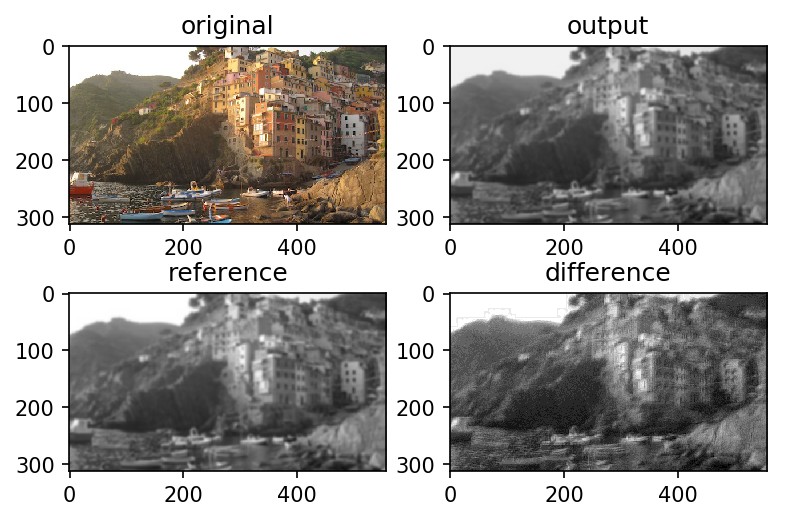

In [0]:
# plot output images
import matplotlib.pyplot as plt
_,ax = plt.subplots(2,2, dpi=150)

ax[0][0].imshow(plt.imread("../src/HW1/cinque_terre_small.jpg"))
ax[0][0].set_title("original")
ax[0][0].grid(False)

ax[0][1].imshow(plt.imread("HW2_output.png"))
ax[0][1].set_title("output")
ax[0][1].grid(False)

ax[1][0].imshow(plt.imread("HW2_reference.png"))
ax[1][0].set_title("reference")
ax[1][0].grid(False)

ax[1][1].imshow(plt.imread("HW2_differenceImage.png"))
ax[1][1].set_title("difference")
ax[1][1].grid(False)

plt.show()